Copyright 2020 DeepMind Technologies Limited.


Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# [Functional Regluarisation for Continual Learning with Gaussian Processes](https://arxiv.org/abs/1901.11356) (Published at ICLR 2020)

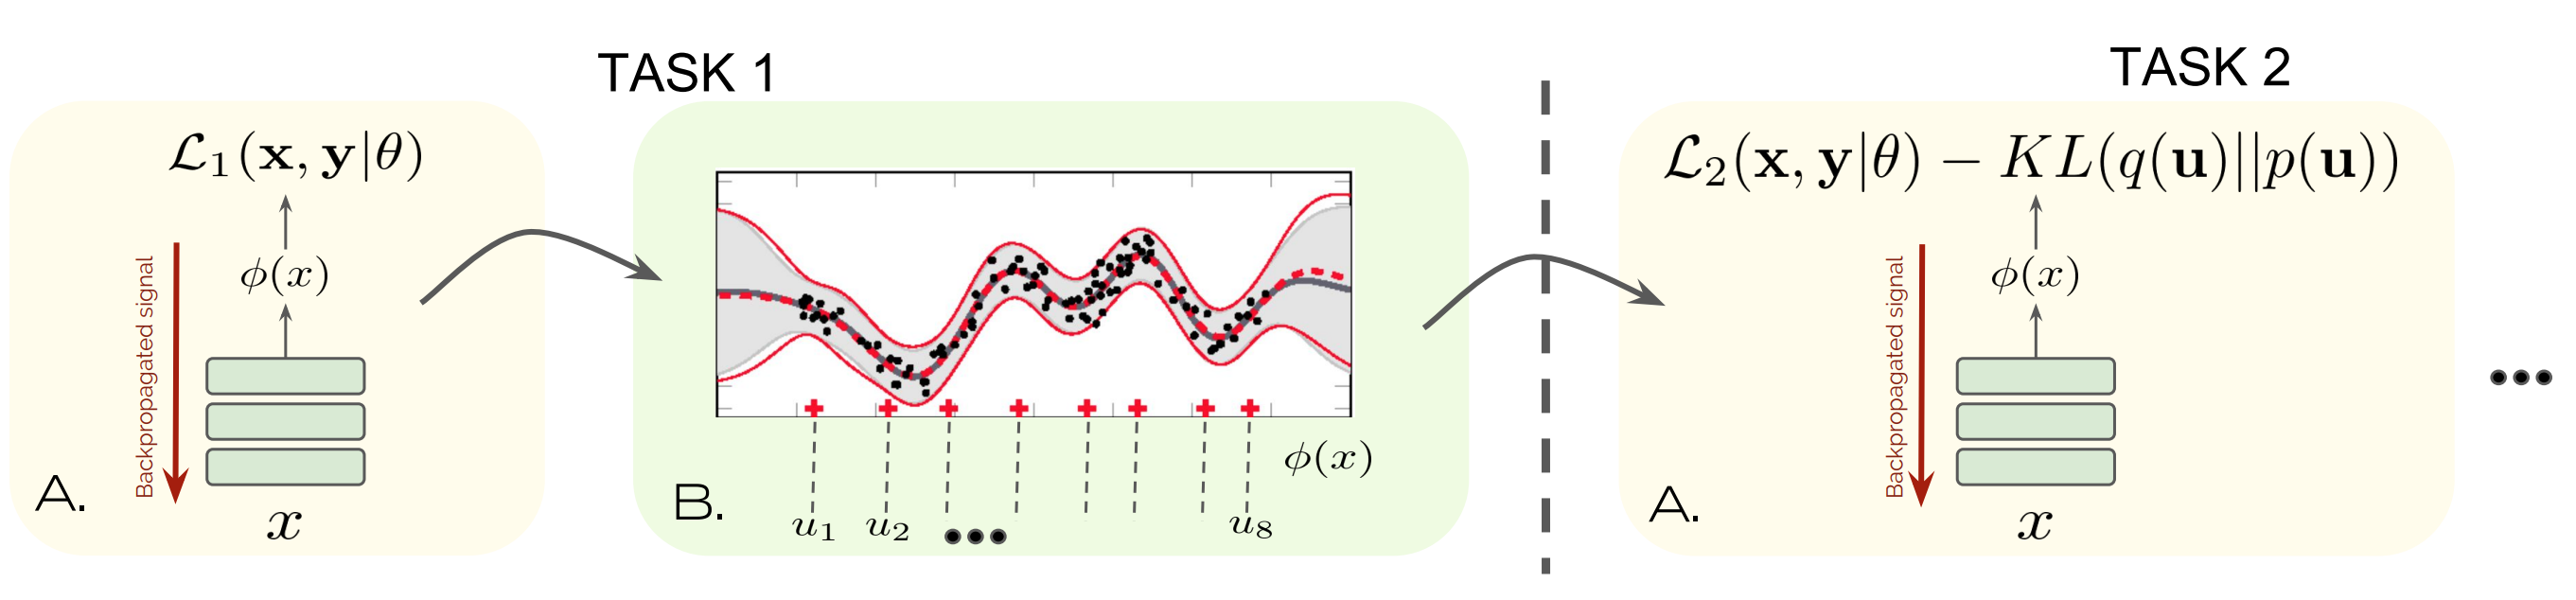






**Functional Regluarisation for Continual Learning (FRCL)** is a method designed to tackle the Continual Learning (CL) problem, combining recent ideas and advances in Bayesian methods, Functional Regularisation and Experience Replay. FRCL is one of the few CL algorithms that provide a principled criterion to choose representative training points for replay. In addition, the Bayesian formulation provides uncertainty estimates that can be used in the task-agonstic setting.


This code implements training and replicates published results presented for the Permuted MNIST and Sequential Omniglot datasets. If you find this code useful, please cite the paper:

```
@article{titsias2019functional,
  title={Functional regularisation for continual learning using gaussian processes},
  author={Titsias, Michalis K and Schwarz, Jonathan and Matthews, AG de G and Pascanu, Razvan and Teh, Yee Whye},
  journal={ICLR 2020},
  year={2020}
}
```
If you have any questions, please do not hestiate to reach out to the
code authors:

*   Jonathan Schwarz (schwarzjn@google.com)
*   Michalis Titsias (mtitsias@google.com)

# Installation and Setup

We begin by installing and importing all necessary dependencies.

In order to allow efficient training, please ensure to use a colab kernel with a GPU by doing the following:

 > `Edit` -> `Notebook settings` -> select GPU under `Hardware accelerator` -> `Save`

In [ ]:
#@title Installing and Importing Dependencies

print('Installing necessary libraries...')

def install_libraries():
  !pip install gpflow
  !pip install dm-sonnet
  !pip install tfa-nightly

import IPython
  
with IPython.utils.io.capture_output() as captured:
  install_libraries()

In [ ]:
#@title Imports

import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

# Python 3 type annotations
from typing import Optional, Sequence, Text, Tuple

Let's define a few useful contants and set some global properties related to plotting and logging.

In [ ]:
#@title Setup

# TF logging level (disables some gpflow internal warnings we can safely ignore)
tf.get_logger().setLevel('ERROR')

# Plotting options
sns.set_style("white")
matplotlib.use('Agg') 
%matplotlib inline

Run the code below to check that you chose the correct colab runtime.

In [ ]:
#@title Test for GPU

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('NOT using a GPU. Please follow the instructions above.')
else:
  print("Using a GPU. You're good to go.")

# Setting up Data

As a first step, we will setup the CL problems to be used in the code below. Specifically, the code below implements the following experiments:

* Permuted MNIST (Proposed as a CL benchmark in [3])
* Sequential Omniglot (Proposed as a CL benchmark in [2])

We start by defining a few useful objects that hold data at various stages throughout the training pipeline:

In [ ]:
#@title Data utility objects

# Holds underlying data source for all tasks. `task_metadata` contains all
# metadata necessary to split this data into a sequence of tasks.
RawData = collections.namedtuple(
    'RawData', ['inputs', 'outputs', 'task_metadata'])

# `RawData` split into train/valid & test sets for a specific task.
DatasetSplit = collections.namedtuple(
    'DatasetSplit', ['train', 'valid', 'test',
                     'num_train', 'num_valid', 'num_test'])

# TF iterators used to fetch data in the training pipeline.
# `train`: Training dataset. Possibly augmented.
# `discr_search`: Dataset to choose replay/inducing points from. Not augmented.
# `discr_search_eval`: Dataset to evaluate inducing point approximation on.
#  Either training or validation set. Not augmented.
# `test`: Test dataset. Not augmented.
Iterators = collections.namedtuple(
    'Iterators', ['train', 'discr_search', 'discr_search_eval', 'test'])

And next define a few functions to operate on those objects, performing converstions along with the necessary processing of those objects.

In [ ]:
#@title Data utility functions

def make_tf_dataset(inputs: tf.Tensor,
                    outputs: tf.Tensor,
                    num_datapoints: int) -> tf.data.Dataset:
  """Create a dataset for supervised learning.

  Args:
    inputs: A tensor of shape `[num_datapoitns, ...]`.
    outputs: Associated outputs. A tensor of shape `[num_datapoitns, ...]`.
    num_datapoints: Number of expected datapoints.
  Returns:
    dataset: A tf.data.Dataset instance. Implements shuffling and repetition.
  """
  dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs))
  return dataset.shuffle(num_datapoints).repeat()

def create_iterators(data: RawData) -> Iterators:
  """Create dataset tensorflow dataset iterators.

  Args:
    data: A RawData object.

  Returns:
    tensorflow Dataset iterators.
  """
  # Setup dataset iterators
  train_iterator = iter(data.train.batch(train_batch_size))
  test_iterator = iter(data.test.batch(data.num_test))

  # Dataset to choose inducing points from
  discr_search_iterator = iter(data.train.batch(data.num_train))
  if data.valid is not None:
    # Dataset to evaluate the quality of the inducing approximation on
    discr_search_eval_iterator = iter(data.valid.batch(data.num_valid))
  else:
    # Use only a quarter fo the train dataset to avoid long training times
    discr_search_eval_iterator = iter(data.train.batch(data.num_train // 4))

  return Iterators(
      train_iterator,
      discr_search_iterator,
      discr_search_eval_iterator,
      test_iterator)

def concat(x: tf.Tensor, y: tf.Tensor) -> tf.Tensor:
  """Concatenates two tensors along first dimension.

  Args:
    x: A tensor of shape `[N, ...]`.
    y: A tensor of shape `[M, ...]`.
  Returns:
    A tensor of shape `[N+M, ...]`.
  """

  return tf.concat([x, y], axis=0)

def select_datapoints(
    data: tf.Tensor,
    select_idx: np.array) -> tf.Tensor:
  """Select subset of datapoints provided by `select_idx` from `data`.

  Args:
    data: A tensor of shape `[num_datapoints, ...]`.
    select_idx: Indices of data to be returned. Shape (N <= num_datapoints, ...)
  Returns:
    A tensor of shape `[N, ...]`.
  """

  return tf.gather(data, select_idx, axis=0)

Let's define all functions necessary to generate the Permuted MNIST benchmark. This includes a function to fetch the data and apply some elimentary preprocessing (returning a `RawData` object) as well as one to split the data into tasks based on different random permuations (returning a `DatasetSplit` object).

In [ ]:
#@title Permuted MNIST

def generate_permutation(num_idx: int) -> Tuple[np.array, np.array]:
  """Create a permuation of `num_idx` indices.

  Args:
    num_idx: Number of indices to be permuted

  Returns:
    perm: Permuted indices.
    inv_perm: Inverse of `perm`. Needed to invert permuation.
  """
  perm = np.random.permutation(range(num_idx))
  inv_perm = np.argsort(perm)
  return perm, inv_perm

def prepare_mnist(num_mnist_tasks: int) -> RawData:
  """Download MNIST data and create permutations.

  Args:
    num_mnist_tasks: How many tasks to use.

  Returns:
    Data re-organised with permutation masks to distinguish between tasks.
  """

  mnist = tf.keras.datasets.mnist.load_data()

  x_train, y_train = mnist[0]
  x_test, y_test = mnist[1]

  all_images = concat(x_train, x_test)
  all_labels = concat(y_train, y_test)

  # Safe scalling and casting
  all_images = tf.image.convert_image_dtype(all_images, tf.float64)
  # Reshape
  all_images = snt.Flatten()(all_images)
  num_indicies = all_images.shape[1]

  # Define permutations
  task_perms, task_inv_perms = zip(*[generate_permutation(num_indicies)
                                     for _ in range(num_mnist_tasks)])

  return RawData(all_images.numpy(), all_labels.numpy(), (task_perms, task_inv_perms))


def load_mnist_permutation(
    full_mnist: RawData,
    task_id: int,
    construct_valid: bool,
    use_data_augmentationt: bool) -> DatasetSplit:
  """Extract data for a single task by premuting and create a train/valid/test split.

  Args:
    full_mnist: Contains original MNIST data. Unpermuted.
    task_id: Id of task requested.
    construct_valid: Whether to construct a validation dataset.
    use_data_augmentationt: Unused.

  Returns:
    Data re-organised with alphabet ids to distinguish between tasks.
  """
  del use_data_augmentationt  # Unused
  # Apply permutation for task given by `task_id`
  permuted_inputs = full_mnist.inputs[:, full_mnist.task_metadata[0][task_id]]

  num_train = 60000
  num_test = 10000

  # Choose a random permutation
  x_test = permuted_inputs[-num_test:]
  y_test = full_mnist.outputs[-num_test:]
  x_train = permuted_inputs[:-num_test]
  y_train = full_mnist.outputs[:-num_test]

  # Construct an optional validation set
  if construct_valid:
    perm = np.random.permutation(num_train)

    num_valid = 10000
    num_train -= num_valid

    x_valid = x_train[perm[:num_valid]]
    y_valid = y_train[perm[:num_valid]]
    x_train = x_train[perm[num_valid:]]
    y_train = y_train[perm[num_valid:]]
    valid_dataset = make_tf_dataset(x_valid, y_valid, num_valid)
  else:
    num_valid = 0
    valid_dataset = None

  train_dataset = make_tf_dataset(x_train, y_train, num_train)
  test_dataset = make_tf_dataset(x_test, y_test, num_test)

  return DatasetSplit(train_dataset, valid_dataset, test_dataset,
                      num_train, num_valid, num_test)

The Omiglot setup is fairly similar with the exception of the additional data augmentation (growing the size of the datset for each task 20-fold) proposed in [2]. This augmentation consists of random rotations and shifts of images which we implement below:

In [ ]:
#@title Data augmentation functions

def random_img_shift_and_rotation(
    imgs: tf.Tensor,
    degree_range: Sequence[float] = None,
    shift_range: Sequence[float] = None) -> tf.Tensor:
  """Augments image tensor by random shifts and rotations.

  Args:
    imgs: A tensor of shape (num_images, num_rows, num_columns, num_channels).
    degree_range: Min./Max. degrees by which each image is rotated.
    shift_range: Min./Max. diff (in both x/y) by which each image is shifted.

  Returns:
    Augmented Image(s) with the same type and shape as images.
  """

  if degree_range is None:
    degree_range = [-30.0, 30.0]

  if shift_range is None:
    shift_range = [-5.0, 5.0]

  num_datapoints = imgs.shape[0]

  # Random rotation
  angles = np.random.uniform(
      degree_range[0], degree_range[1], size=num_datapoints)
  imgs = tfa.image.rotate(imgs, np.radians(angles))

  # Random shift (https://stackoverflow.com/questions/42252040/how-to-translateor-shift-images-in-tensorflow/45662771)
  diff = np.random.uniform(shift_range[0], shift_range[1],
                           size=num_datapoints*2).reshape(num_datapoints, 2)
  transforms = np.tile([[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]],
                       [num_datapoints, 1]).astype(np.float32)
  transforms[:, 2] = -diff[:, 0]
  transforms[:, 5] = -diff[:, 1]

  return tfa.image.transform(imgs, transforms)

Setting up the rest of the functions for Seq. Omniglot:

In [ ]:
#@title Sequential Omniglot

def prepare_omniglot(num_alphabets: int) -> RawData:
  """Download Omniglot data and merge original train/test sets.

  Args:
    num_alphabets: How many alphabets to use. Must be <= 50.

  Returns:
    Data re-organised with alphabet ids to distinguish between tasks.
  """
  # The original train/test split is designed for few-shot learning. As this
  # split no longer applies to us, we will merge this data and perform a manual
  # train/test split later on.
  omniglot_train_ds = tfds.load(
      'omniglot', batch_size=-1, split='train',
      as_supervised=False, shuffle_files=False)
  omniglot_test_ds = tfds.load(
      'omniglot', batch_size=-1, split='test',
      as_supervised=False, shuffle_files=False)

  # The provided train/test split does not apply, so we'll merge and re-organise
  all_images = concat(
      omniglot_train_ds['image'], omniglot_test_ds['image'])
  all_labels = concat(
      omniglot_train_ds['alphabet_char_id'],
      omniglot_test_ds['alphabet_char_id'])

  # Allows us to distinguish between tasks (i.e. alphabets)
  all_alphabet_ids = concat(
      omniglot_train_ds['alphabet'],
      omniglot_test_ds['alphabet']).numpy()

  # To determine the size of a prediction vector.
  num_chars_per_alphabet = [tf.reduce_max(select_datapoints(all_labels, np.argwhere(all_alphabet_ids == t))).numpy()
                            for t in range(num_alphabets)]

  # Discard all data not needed
  idx = np.argwhere(all_alphabet_ids < num_alphabets).flatten()
  all_alphabet_ids = all_alphabet_ids[idx]
  all_images = select_datapoints(all_images, idx)
  all_labels = select_datapoints(all_labels, idx)

  return RawData(all_images, all_labels, (all_alphabet_ids, num_chars_per_alphabet))


def load_omniglot_alphabet(
    full_omniglot: RawData,
    alphabet_id: int,
    construct_valid: bool,
    use_data_augmentationt: bool) -> DatasetSplit:
  """Extract a single alphabet, preprocess and create a train/valid/test split.

  Args:
    full_omniglot: Contains Omniglot data of all alphabets.
    alphabet_id: Id of alphabet requested. Must be <= 50.
    construct_valid: Whether to construct a validation dataset.
    use_data_augmentationt: Whether to augment the dataset.

  Returns:
    Data re-organised with alphabet ids to distinguish between tasks.
  """
  # Selecting an alphabet
  idx = np.argwhere(full_omniglot.task_metadata[0] == alphabet_id).flatten()
  alphabet_images = select_datapoints(full_omniglot.inputs, idx)
  alphabet_labels = select_datapoints(full_omniglot.outputs, idx)

  # Pre-processing
  alphabet_images = tf.image.convert_image_dtype(alphabet_images, tf.float32)
  alphabet_images = tf.image.rgb_to_grayscale(alphabet_images)
  # Resize and invert colour (from black on white background to white on black).
  alphabet_images = 1.0 - tf.image.resize(alphabet_images, [28, 28])
  alphabet_images = tf.cast(alphabet_images, tf.float64)

  num_datapoints = alphabet_labels.shape[0]

  # Let's shuffle the datapoints randomnly.
  perm = np.random.permutation(num_datapoints)
  alphabet_images = select_datapoints(alphabet_images, perm)
  alphabet_labels = select_datapoints(alphabet_labels, perm)

  # Number of datapoints in alphabet
  num_datapoints = alphabet_images.shape[0]
  num_test = int(np.ceil(0.2 * num_datapoints))

  # Choose a test set (20% of all data).
  x_test = alphabet_images[:num_test]
  y_test = alphabet_labels[:num_test]

  # Construct an optional validation set (20% of all data).
  if construct_valid:
    num_valid = num_test

    x_valid = alphabet_images[num_test:num_test+num_valid]
    y_valid = alphabet_labels[num_test:num_test+num_valid]
    valid_dataset = make_tf_dataset(x_valid, y_valid, num_valid)
  else:
    num_valid = 0
    valid_dataset = None

  # Use the remaining data for the training set.
  num_train = num_datapoints - num_valid - num_test
  x_train = alphabet_images[-num_train:]
  y_train = alphabet_labels[-num_train:]

  # Dataset Augmentation proposed in [2].
  if use_data_augmentationt:
    num_train *= 20
    x_train = tf.concat([x_train] + [random_img_shift_and_rotation(x_train)
                                     for _ in range(19)], axis=0)
    y_train = tf.tile(y_train, [20])

  train_dataset = make_tf_dataset(x_train, y_train, num_train)
  test_dataset = make_tf_dataset(x_test, y_test, num_test)

  return DatasetSplit(train_dataset, valid_dataset, test_dataset,
                      num_train, num_valid, num_test)

# Implementing FRCL

There are two key architectural components: 
- (i) A neural network defining the feature mapping $\phi(x)$.
- (ii) A Sparse Variational Gaussian Process operating on the feature mapping. 

We will use standard networks for (i) and focus our attention primarily on the implementation of (ii). The code below uses Sonnet to build Neural Network Architectures and GPFlow to implement sparse GPs:

In [ ]:
#@title Import Sonnet & GPFlow

import gpflow
import sonnet as snt

For Permuted MNIST, we use a standard Sonnet Multi-Layer Perceptron (MLP) which we augment by concatenating a bias term for the GP:

In [ ]:
#@title Define an MLP Network to provide the feature mapping for MNIST

class MLPNetworkWithBias(snt.nets.MLP):
  """Fully connected MLP base network using Sonnet."""

  def __call__(self, inputs: tf.Tensor, *args, **kwargs) -> tf.Tensor:
    """Applies MLP to `inputs` and adds a column of ones to the feature matrix.

    Args:
      inputs: A Tensor of shape `[batch_size, num_input_dimensions]`.
      *args: Arguments to snt.nets.MLP. See Sonnet documentation.
      **kwargs: Named arguments to snt.nets.MLP. See Sonnet documentation.

    Returns:
      outputs: Model output and bias term of shape `[batch_size, output_size+1]`.
    """
    outputs = super(MLPNetworkWithBias, self).__call__(inputs, *args, **kwargs)

    # Add a column of ones to the feature vector to account for the bias
    outputs = tf.concat(
        [outputs, tf.ones((outputs.shape[0], 1), dtype=outputs.dtype)], axis=1)

    return outputs

For Sequential Omniglot, we use a good old-fashioned ConvNet with MaxPooling which we define below:

In [ ]:
#@title Define a Conv. Network to provide the feature mapping for Omniglot

class ConvNetworkWithBias(snt.Module):
  """Builds a module out of a sequence of callables."""

  def __init__(self,
               output_sizes: Sequence[int],
               data_format: Text = 'NHWC',
               conv_padding: Text = 'SAME',
               conv_kernel_shape: Sequence[int] = None,
               conv_kernel_stride: Sequence[int] = None,
               maxpool_padding: Text = 'VALID',
               maxpool_kernel_shape: Sequence[int] = None,
               maxpool_kernel_stride: Sequence[int] = None,
               name: Optional[Text] = None):
    """Constructor for ConvNetworkWithBias.

    Args:
      output_sizes: Defines the number of output channels for each ConvLayer.
      data_format: Specifies semantics for each input batch dimension.
      conv_padding: Either `SAME` or `VALID`.
      conv_kernel_shape: Size of the convolutional kernel.
      conv_kernel_stride: Convolution stride.
      maxpool_padding: Either `SAME` or `VALID`.
      maxpool_kernel_shape: Size of the maxpool kernel.
      maxpool_kernel_stride: MaxPool stride.
      name: Optional model name.
    """
    super(ConvNetworkWithBias, self).__init__(name=name)

    if conv_kernel_shape is None:
      conv_kernel_shape = [3, 3]
    if conv_kernel_stride is None:
      conv_kernel_stride = [1, 1]
    if maxpool_padding is None:
      maxpool_padding = 'VALID'
    if maxpool_kernel_shape is None:
      maxpool_kernel_shape = [1, 2, 2, 1]
    if maxpool_kernel_stride is None:
      maxpool_kernel_stride = [1, 2, 2, 1]

    self._output_sizes = output_sizes
    self._num_layers = len(self._output_sizes)
    self._conv_kernel_shapes = [conv_kernel_shape] * self._num_layers
    self._conv_strides = [conv_kernel_stride] * self._num_layers
    self._maxpool_kernel_shapes = [maxpool_kernel_shape] * self._num_layers
    self._maxpool_kernel_strides = [maxpool_kernel_stride] * self._num_layers

    # Instantiate modules
    self._conv_modules = list(
        snt.Conv2D(  # pylint: disable=g-complex-comprehension
            output_channels=self._output_sizes[i],
            kernel_shape=self._conv_kernel_shapes[i],
            stride=self._conv_strides[i],
            padding=conv_padding,
            data_format=data_format,
            name='conv_2d_{}'.format(i))
        for i in range(self._num_layers))
    
    self._maxpool_modules = list(
        lambda x: tf.nn.max_pool(x, 
                                 ksize=self._maxpool_kernel_shapes[i],
                                 strides=self._maxpool_kernel_strides[i],
                                 padding=maxpool_padding,
                                 data_format=data_format,
                                 name='maxpool_2d_{}'.format(i)) 
        for i in range(self._num_layers))
    self._flatten = snt.Flatten(name='Flatten')

  def __call__(self, inputs: tf.Tensor) -> tf.Tensor:
    """Applies ConvNet to `inputs` and adds a column of ones to the feature matrix.

    Args:
      inputs: A Tensor of shape `[batch_size, height, width, num_channels]`.

    Returns:
      outputs: Model output and bias term `[batch_size, output_size+1]`.
    """

    # Ensure correct data type
    original_dtype = inputs.dtype
    outputs = tf.cast(inputs, tf.float32)

    for conv_layer, maxpool_layer in zip(
        self._conv_modules, self._maxpool_modules):
      outputs = conv_layer(outputs)
      outputs = maxpool_layer(outputs)
      outputs = tf.nn.relu(outputs)

    outputs = self._flatten(outputs)
    # Add a column of ones to the feature vector to account for the bias
    outputs = tf.concat(
        [outputs, tf.ones((outputs.shape[0], 1), dtype=outputs.dtype)], axis=1)

    return tf.cast(outputs, original_dtype)

Let's turn our attention to (ii) Implementing the GP to work on the feature embedding. This is the heart of FRCL:

In [ ]:
#@title Implementing FRCL

class BaseInducingApproximation(object):
  """Holds the parameters of a posterior approximation."""
  def __init__(self,
               q_z: tf.Tensor,
               q_mean: tf.Variable,
               q_sqrt: tf.Variable,
               q_z_init: tf.Tensor):
    """Constructor for BaseInducingApproximation.

    Args:
      q_z: Inducing points. A Tensor of shape `[num_inducing_points, num_input_features]`.
      q_mean: Mean of the variational distribution of shape `[num_inducing_points, num_classes]`.
      q_sqrt: Cholesky (sqrt) matrices of the variational distribution `[]`.
      q_z_init: Initial inducing points. A Tensor of shape `[num_inducing_points, num_input_features]`.
    """
    self.q_z = q_z
    self.q_mean = q_mean
    self.q_sqrt = q_sqrt
    self.q_z_init = q_z_init


class InducingApproximation(BaseInducingApproximation):
  """Creates a variational approximation in function/GP space."""

  def __init__(self,
               num_inducing_points: int,
               num_classes: int,
               inducing_init_value: tf.Tensor):
    """Constructor for InducingApproximation.

    Args:
      num_inducing_points: Number of inducing points to use.
      num_classes: Number of classes in classification problem.
      inducing_init_value: Initial value. A Tensor of shape `[num_inducing_points, num_input_features]`.
    """
    q_mean = tf.Variable(np.zeros(
        (num_inducing_points, num_classes)).astype(np.float64))
    q_sqrt = tf.Variable(np.array(
        [np.eye(num_inducing_points).astype(np.float64)
         for _ in range(num_classes)]).T)

    q_z = tf.constant(inducing_init_value)
    q_z_init = tf.constant(inducing_init_value)
    super(InducingApproximation, self).__init__(q_z, q_mean, q_sqrt, q_z_init)


class WeightSpaceApproximation(object):
  """Creates a variational approximation in weight space."""

  def __init__(self,
               num_features: int,
               num_classes: int,
               rng: np.random.RandomState):
    """Constructor for WeightSpaceApproximation.

    Args:
      num_features: Number of inducing points to use.
      num_classes: Number of classes in classification problem.
      rng: Random number generator.
    """
    scalar = 1.0/np.sqrt(num_features)
    self.q_w_mean = tf.Variable(scalar*rng.randn(
        num_features, num_classes).astype(np.float64))
    self.q_w_sqrt = tf.Variable(np.array(
        [np.eye(num_features).astype(np.float64)
         for _ in range(num_classes)]).T)

class ContinualGPmodel(object):
  """Continual learning GP-based model tha uses variational inducing points."""

  def __init__(self,
               num_input_dimensions: int,
               num_features: int,
               num_classes: int,
               base_network: snt.Module,
               likelihood: gpflow.likelihoods,
               noise_variance: float = 1e-3):
    """Constructor for continual GP model.

    Args:
      num_input_dimensions: Dimensionality of the input space.
      num_features: Size of the feature including the bias term.
      num_classes: Number of classes in classification problem.
      base_network: Provides the feature mappping.
      likelihood: Likelihood for the datatype at hand.
      noise_variance: Added to diagonal of covariance matrix.
    """

    self.num_input_dimensions = num_input_dimensions
    self.num_features = num_features
    self.num_classes = num_classes
    self.past_inducing_approxs = []
    self.current_inducing_approx = None
    self.current_weight_space_approx = None
    self.base_network = base_network
    self.likelihood = likelihood
    # Constant noise/jitter to be added only to the inducing point covariances
    self.noise_variance = tf.constant(noise_variance, dtype=tf.float64)

  def get_weight_space_approx(self, rng):
    """Initialise a new weight space approximation.

    Args:
      rng: Random number generator.
    """
    self.current_weight_space_approx = WeightSpaceApproximation(
        self.num_features, self.num_classes, rng)

  def covariance_self(self, matrix_a: tf.Tensor) -> tf.Tensor:
    """Compute linear kernel plus noise for features with themself.

    Args:
      matrix_a: Matrix of shape `[batch, num_features]`.

    Returns:
      Covariance matrix of shape `[batch, batch]`.

    """
    return tf.matmul(
        matrix_a, matrix_a, transpose_b=True) + self.noise_variance * tf.eye(
            tf.cast(matrix_a.shape[0], tf.int32), dtype=tf.float64)

  def covariance_cross(self,
                       matrix_a: tf.Tensor,
                       matrix_b: tf.Tensor) -> tf.Tensor:
    """Compute linear kernel for features with other features.

    No noise in these case because features are assumed distinct.

    Args:
      matrix_a: Tensor of shape `[batch_a, num_features]`.
      matrix_b: Tensor of shape  `[batch_b, num_features]`.

    Returns:
      Covariance matrix of shape `[batch_a, batch_b]`.

    """
    return tf.matmul(matrix_a, matrix_b, transpose_b=True)

  def covariance_diag(self, matrix: tf.Tensor) -> tf.Tensor:
    """Compute diagonal of linear kernel matrix for features with themself.

    Args:
      matrix: Tensor of shape `[batch, num_features]`.

    Returns:
      Diagonal covariance vector of shape `[batch]`.
    """

    # We do not add noise_variance/jitter to this diagonal, but only to the
    # inducing matrix, so inducing variables are noisy function values and
    # through them we approximate the exact noise-free GP model.
    return tf.reduce_sum(matrix * matrix, axis=1)

  def objective_weight_space(self,
                             inputs: tf.Tensor,
                             outputs: tf.Tensor,
                             num_task_points: int):
    """Compute the variational objective for the model.

    Args:
      inputs: A Tensor of shape `[batch_size, num_input_dimensions]`.
      outputs: Class labels. Shape (batch, num_classes).
      num_task_points: Total number of data points in task.

    Returns:
      variational objective for the bound.
    """
    batch_size = tf.cast(inputs.shape[0], tf.int32)

    # Add KL divergences for the all previous tasks.
    # Rightmost term of Eq. (4) in the paper.
    kl_historical = 0
    for inducing_approx in self.past_inducing_approxs:
      # z_features shape (num_inducing_points, num_features)
      z_features = self.base_network(inducing_approx.q_z)
      # p_cov shape (num_inducing_points, num_inducing_points)
      p_cov = self.covariance_self(z_features)
      kl_historical += gpflow.kullback_leiblers.gauss_kl(
          inducing_approx.q_mean,
          tf.transpose(inducing_approx.q_sqrt, (2, 0, 1)),
          K=p_cov)

    # For the current task we do inference in the weight space
    data_features = self.base_network(inputs)
    data_mean = tf.matmul(data_features,
                          self.current_weight_space_approx.q_w_mean)

    tr_q_w_sqrt = tf.compat.v1.matrix_band_part(tf.transpose(
        self.current_weight_space_approx.q_w_sqrt, (2, 0, 1)), -1, 0)
    expand_data_features = tf.tile(
        tf.expand_dims(data_features, 0), [self.num_classes, 1, 1])
    feat_w_sqrt = tf.matmul(expand_data_features, tr_q_w_sqrt)
    data_var = tf.transpose(tf.reduce_sum(tf.square(feat_w_sqrt), axis=2))

    # Middle term of Eq. (4) in the paper.
    kl_current = gpflow.kullback_leiblers.gauss_kl(
        self.current_weight_space_approx.q_w_mean,
        tf.transpose(self.current_weight_space_approx.q_w_sqrt, (2, 0, 1)),
        K=None)

    # Left term of Eq. (4) in the paper.
    exp_likes = self.likelihood.variational_expectations(
        data_mean, data_var, outputs)
    # Scale this correclty by the total number of datapoints in the task.
    ratio = tf.cast(
        num_task_points, tf.float64) / tf.cast(batch_size, tf.float64)
    reconstruction_cost = tf.reduce_sum(exp_likes) * ratio

    # Full objective. Eq. (4) in the paper.
    objective = kl_historical + kl_current - reconstruction_cost
    return objective, reconstruction_cost, kl_current

  def trace_term(self,
                 inputs: tf.Tensor,
                 q_z: tf.Tensor) -> tf.Tensor:
    """Compute the trace term. Useful for search over inducing points.

    Args:
      inputs: A Tensor of shape `[batch_size, num_input_dimensions]`.
      q_z: Inducing points of shape `[num_inducing_points, num_input_dimensions]`.

    Returns:
      variational objective for the bound.
    """

    # Shape [num_inducing_points, num_features]
    inducing_features = self.base_network(q_z)
    # Shape [batch_size, num_features]
    data_features = self.base_network(inputs)

    # Compute covariance
    kmn = self.covariance_cross(inducing_features, data_features)
    kmm = self.covariance_self(inducing_features)
    knn = self.covariance_diag(data_features)

    # Implements Equation (6) in the paper and speeds up computations by
    # applying the matrix inversion formula if needed.
    if q_z.shape[0] <= self.num_features:
      lm = tf.compat.v1.cholesky(kmm)
      v = tf.compat.v1.matrix_triangular_solve(lm, kmn, lower=True)
      fvar = knn - tf.reduce_sum(tf.square(v), 0)
    else:
      phimphim = tf.matmul(inducing_features, inducing_features,
                           transpose_a=True)
      phimphim_noise = phimphim + self.noise_variance * tf.eye(
          tf.cast(self.num_features, tf.int32), dtype=tf.float64)

      sqrt_phimphin_noise = tf.compat.v1.cholesky(phimphim_noise)

      inv_sqrt_phimphin_noise_phim = tf.compat.v1.matrix_triangular_solve(
          sqrt_phimphin_noise, tf.transpose(inducing_features),
          lower=True)
      v = tf.matmul(inv_sqrt_phimphin_noise_phim, kmn)

      fvar = knn - (1.0/self.noise_variance)*(
          tf.reduce_sum(tf.square(kmn), 0) - tf.reduce_sum(tf.square(v), 0))

    return tf.reduce_sum(fvar)

  def function_space_prediction(self,
                                inputs: tf.Tensor,
                                q_z: tf.Tensor,
                                q_mean: tf.Variable,
                                q_sqrt: tf.Variable,
                                outputs: tf.Tensor = None):
    """Compute predictions from the model in function/GP space.

    Args:
      inputs: Tensor of shape `[batch, num_input_dimensions]`.
      q_z: Inducing points of shape `[num_inducing_points, input_dimensions]`.
      q_mean: Mean of the variational distribution of shape `[num_inducing_points, num_classes]`.
      q_sqrt: Cholesky (sqrt) matrices of the variational distribution `[]`.
      outputs: Class labels. Optional tensor of Shape `[batch, num_clsses]`.

    Returns:
      When outputs=None, it returns predictive mean and variance from model
      otherwise it returns the log predictive density for the outputs.
    """

    inducing_features = self.base_network(q_z)
    data_features = self.base_network(inputs)

    # Compute covariance
    kmn = self.covariance_cross(inducing_features, data_features)
    kmm = self.covariance_self(inducing_features)
    knn = self.covariance_diag(data_features)

    func_mean, func_var = gpflow.conditionals.base_conditional(
        kmn, kmm, knn, f=q_mean, q_sqrt=tf.transpose(q_sqrt, (2, 0, 1)),
        full_cov=False, white=False)

    if outputs is None:
      return self.likelihood.predict_mean_and_var(func_mean, func_var)
    else:
      return self.likelihood.predict_density(func_mean, func_var, outputs)

  def complete_task_weight_space(self,
                                 z: tf.Tensor,
                                 z_init: tf.Tensor):
    """Completes training of current task in weight space.

    Args:
      z: Final inducing points for current task of shape `[num_inducing_points, num_features]`.
      z_init: Initial inducing points for current task of shape  `[num_inducing_points, num_features]`.
    """

    current_inducing_features = self.base_network(z)
    current_q_mean = tf.matmul(
        current_inducing_features, self.current_weight_space_approx.q_w_mean)
    noise_matrix = self.noise_variance * tf.eye(
        tf.cast(tf.shape(z)[0], tf.int32), dtype=tf.float64)
    noise_matrix = tf.tile(
        tf.expand_dims(noise_matrix, 0), [self.num_classes, 1, 1])
    tr_q_w_sqrt = tf.linalg.band_part(tf.transpose(
        self.current_weight_space_approx.q_w_sqrt, (2, 0, 1)), -1, 0)
    expand_current_inducing_features = tf.tile(
        tf.expand_dims(current_inducing_features, 0), [self.num_classes, 1, 1])
    feat_w_sqrt = tf.matmul(expand_current_inducing_features, tr_q_w_sqrt)
    q_cov = tf.matmul(feat_w_sqrt, feat_w_sqrt, transpose_b=True)
    q_cov = q_cov + noise_matrix
    current_q_sqrt = tf.transpose(tf.compat.v1.cholesky(q_cov), (1, 2, 0))

    self.past_inducing_approxs.append(
        BaseInducingApproximation(z, tf.identity(current_q_mean),
                                  tf.identity(current_q_sqrt), z_init))

The only remaning bit is to define the evaluation functions that allow us to measure model performance:

In [ ]:
#@title Evaluation utility functions

def get_accuracy_rate(
    predictions: np.array,
    labels: np.array) -> float:
  """Compute mean classification accuracy.

  Args:
    predictions: A numpy array of shape `[batch_size, input_size]`.
    labels: Ground truth labels of shape `[batch_size, input_size]`.

  Returns:
    outputs: Model output and bias term `[batch_size, output_size+1]`.
  """
  return np.mean(np.equal(np.argmax(predictions, axis=1), labels))

def evaluate_on_all_tasks(
    eval_iterators: Sequence[Iterators],
    model: ContinualGPmodel) -> Sequence[float]:
  """Evaluates models on all tasks. Assumes iterators provide entire dataset.

  Args:
    eval_iterators: Provides entire data to evaluate model on. One per task.
    model: A ContinualGPmodel to be evaluated.

  Returns:
    List of accuracies achieved on each task.
  """

  # Evaluate test accuracies for all tasks
  eval_accuracies = []
  for task, eval_iterator in enumerate(eval_iterators):
    # Fetch the whole eval dataset
    eval_input, eval_output = next(eval_iterator)

    # Model prediction
    pred_prob = model.function_space_prediction(
        eval_input,
        model.past_inducing_approxs[task].q_z,
        model.past_inducing_approxs[task].q_mean,
        model.past_inducing_approxs[task].q_sqrt)[0]

    test_accuracy_rate = get_accuracy_rate(pred_prob, eval_output)
    eval_accuracies.append(test_accuracy_rate)

  return eval_accuracies

# Training

Now that we've set up the model, let's define a basic Continual Learning Setup. The next code block allows you to choose between the two data sources and vary some of the fundamental CL experimental parameters. The values suggested below are those used in the paper to report result.

In [ ]:
#@title Defining the training protocol

exp_name = 'Permuted MNIST'  #@param ["Permuted MNIST", "Sequential Omniglot"] {allow-input: false}

# Random number generator
rng_seed = 42  #@param
rng_state = np.random.RandomState(rng_seed)

#@markdown P-MNIST: 10 Omniglot: 50
num_tasks = 11  #@param {type:"slider", min:1, max:1000, step:1}

# General training settings (Default: Permuted MNIST)
learning_rate = 1e-3  #@param
#@markdown P-MNIST: 128 Omniglot: 32
train_batch_size = 128  #@param {type:"slider", min:1, max:1000, step:1}
#@markdown P-MNIST: 2000 Omniglot: 2500
num_train_iters = 2000  #@param {type:"slider", min:1, max:5000, step:1}
use_validation_dataset = False  #@param {type:"boolean"}


# FRCL settings
which_discrete_loss = 'trace_term'  #@param ["trace_term", "random"] {allow-input: false}
num_optim_steps_discrete_search = 1000  #@param {type:"slider", min:1, max:5000, step:1}

#@markdown Only used for Omniglot
use_data_augmentation = False  #@param {type:"boolean"}


if exp_name == 'Permuted MNIST':
  tasks = list(range(num_tasks))
  download_data = prepare_mnist
  load_task_data = load_mnist_permutation

  # MLP Size. Based on the experimental protocol in [1].
  hidden_units = [100, 100]

  num_output_dim = 10

  # Instantiate network that defines the feature mapping
  BaseNetwork = MLPNetworkWithBias

  if use_data_augmentation:
    print('Data augmentation is non-standard with Permuted MNIST. Ignoring option.')
    use_data_augmentation = False
elif exp_name == 'Sequential Omniglot':
  tasks = list(range(num_tasks))
  assert num_tasks <= 50, 'Only 50 tasks are available'

  download_data = prepare_omniglot
  load_task_data = load_omniglot_alphabet

  # ConvNet output channels. Based on the experimental protocol in [2].
  hidden_units = [64, 64, 64, 64]

  # This is the maximum number of characters in any Omniglot alphabet
  num_output_dim = 54

  # Instantiate network that defines the feature mapping
  BaseNetwork = ConvNetworkWithBias
else:
  print('unknown dataset')

print('\nDownloading dataset...')
with IPython.utils.io.capture_output() as captured:
  raw_data = download_data(num_tasks)

#@markdown P-MNIST: 200 Omniglot: 2 (to be multiplied by the #characters/alphabet)
num_inducing_points_per_task = 200  #@param {type:"slider", min:1, max:1000, step:1}

# The specification of inducing points is absolute for P-MNIST and relative to the number of characters/alphabet for Omniglot
if exp_name == 'Permuted MNIST':
  num_inducing_points_per_task = [num_inducing_points_per_task] * num_tasks
else:
  num_inducing_points_per_task = [num_inducing_points_per_task * t for t in
                                  raw_data.task_metadata[1]]

Let's setup data iterators and instatiate an FRCL model:

In [ ]:
#@title Instantiate model

num_pixels = 784
num_gp_features = hidden_units[-1] + 1  # Add one to account for the bias

# Instantiate Continal Learning Gaussian Process Model
model_likelihood = gpflow.likelihoods.MultiClass(num_output_dim)
network = BaseNetwork(output_sizes=hidden_units)
FRCL = ContinualGPmodel(num_pixels, num_gp_features,
                        num_output_dim, network, model_likelihood)

Let's start training. The code below runs the main training loop:

In [ ]:
#@title Main training loop

discr_search_losses = []
test_accuracies = []
test_iterators = []

for t in range(num_tasks):
  print('Learning task {}'.format(t+1))
  discr_search_loss = []

  task_data = load_task_data(raw_data, t,
                             use_validation_dataset,
                             use_data_augmentation)
  iterators = create_iterators(task_data)

  # Get a weight space approximation for the current task
  FRCL.get_weight_space_approx(rng_state)
  # Set up a task-specific optimiser
  optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

  # --- Task Training ---
  print('\tStarting optimisation')
  for training_index in range(num_train_iters):
    train_inputs, train_outputs = next(iterators.train)

    def loss_fn():
      train_loss, _, _ = FRCL.objective_weight_space(
          train_inputs, train_outputs, task_data.num_train)

      return train_loss

    optimizer.minimize(loss_fn)

  print('\tFinished training')

  # --- Discrete inducing point Optimisation ---
  num_inducing_points_for_task = num_inducing_points_per_task[t]

  # Select a random set of inducing inputs from the discrete search set
  x_discr = next(iterators.discr_search)[0]
  perm_train = np.random.permutation(task_data.num_train)

  z_idx = perm_train[-num_inducing_points_for_task:]
  z_ = select_datapoints(x_discr, z_idx)

  if 'random' == which_discrete_loss:
    print('\tUsing random inducing points')
  elif 'trace_term' == which_discrete_loss:
    # Indicates a candidate training point to replace the inducing point with
    train_set_id = 0

    # Data to evaluate inducing set on
    discr_search_input, _ = next(iterators.discr_search_eval)
    current_loss = -FRCL.trace_term(discr_search_input, z_)
    discr_search_loss.append((0, current_loss, z_))

    accepted_moves = 0
    print('\tOptimising inducing points using discrete search.')
    for disr_search_iter in range(num_optim_steps_discrete_search):
      inducing_set_id = disr_search_iter % num_inducing_points_for_task
      z_idx_proposed = z_idx.copy()

      # Replace inducing point and re-evaluate
      z_idx_proposed[inducing_set_id] = perm_train[train_set_id]
      proposed_loss = -FRCL.trace_term(
          discr_search_input, select_datapoints(x_discr, z_idx_proposed))

      if proposed_loss > current_loss:
        z_idx = z_idx_proposed.copy()
        current_loss = proposed_loss
        accepted_moves += 1

        discr_search_loss.append(
            (disr_search_iter, current_loss, z_))

      if train_set_id == task_data.num_train-1:
        perm_train = np.random.permutation(task_data.num_train)
        train_set_id = 0
      else:
        train_set_id += 1

    print('\tAccepted moves: {}'.format(accepted_moves))
  discr_search_losses.append(discr_search_loss)

  # --- Complete the task ---
  FRCL.complete_task_weight_space(z_, discr_search_loss[0][2])

  # --- Evaluation on all tasks thus far ---
  test_iterators.append(iterators.test)
  test_accuracies.append(
      evaluate_on_all_tasks(test_iterators, FRCL))

print('Done.')

mean_test_accuracy = list(map(np.mean, test_accuracies))

print('\n---\nFinal accuracy: {}\n---'.format(mean_test_accuracy[-1]))

Let's visualise overall (first column) along with task-specific performance that allows us to visualise forward/backward transfer:

In [ ]:
#@title Visualising overall and per-task accuracies

from matplotlib.ticker import MaxNLocator


def _format_axis(axis: matplotlib.pyplot.axis,
                 y_limit: Sequence[float],
                 title_str: Text = None):
  """Format axis.

  Args:
    axis: Axis to format.
    y_limit: Limit to apply on the y-axis.
    title_str: String to use for axis title.
  """
  axis.set_xlim((0.5, num_tasks + 0.5))
  axis.set_ylim(y_limit)
  # Force only integer tirkcs
  axis.xaxis.set_major_locator(MaxNLocator(integer=True))

  if title_str is not None:
    axis.set_title(title_str)


colours = sns.color_palette()

fig = plt.figure(figsize=(10, 10))
layout = (int(np.ceil(num_tasks / 2) + 1), 2)
ylim = (np.min([np.min(t) for t in test_accuracies]) * 0.975, 1.0)

# Plot the overall mean accuracy
ax = plt.subplot2grid(layout, (0, 0), colspan=2)
ax.plot(range(1, num_tasks + 1), mean_test_accuracy, marker='o', c='k')
ax.set_xlabel('Evaluated after learning task')
ax.set_ylabel('Test accuracy (%)')
_format_axis(
    ax, ylim,
    'Overall mean test accuracy: FRCL ({})'.format(which_discrete_loss))

# Plot results for each task
for t in range(num_tasks):
  ax = plt.subplot2grid(layout, (t // 2 + 1, t % 2))
  ax.plot(
      range(t + 1, num_tasks + 1),
      test_accuracies[-t - 1],
      marker='o',
      c=colours[t])

  _format_axis(ax, ylim, 'Test accuracy for task: {}'.format(t + 1))

sns.despine()
plt.tight_layout()
plt.show()

The code below allows us to look at some of the inducing points we optimised for. Each row shows inducing points for a different task:

In [ ]:
#@title Visualising inducing points

num_inducing_points_per_task_to_show = 20  #@param
max_number_of_tasks = 5  #@param

max_number_of_tasks = min(max_number_of_tasks, num_tasks)
num_inducing_points_per_task_to_show = min(
    num_inducing_points_per_task_to_show, max(num_inducing_points_per_task))

fig, axarr = plt.subplots(
    max_number_of_tasks,
    num_inducing_points_per_task_to_show,
    figsize=(10, 10))

for i in range(max_number_of_tasks):
  task_inducing_points = FRCL.past_inducing_approxs[i].q_z.numpy()

  if 'Permuted MNIST' == exp_name:
    task_inv_perm = raw_data.task_metadata[1][i]
    # Apply inverse permutation to allow visualisation
    task_inducing_points = task_inducing_points[:, task_inv_perm]
  task_inducing_points = task_inducing_points.reshape([-1, 28, 28])
  for j in range(num_inducing_points_per_task_to_show):
    axarr[i, j].imshow(task_inducing_points[j], cmap='gray')
    axarr[i, j].axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# References

[1] Zenke, Friedemann, Ben Poole, and Surya Ganguli. "Continual learning through synaptic intelligence." Proceedings of machine learning research 70 (2017): 3987.

[2] Schwarz, J., Luketina, J., Czarnecki, W. M., Grabska-Barwinska, A., Teh, Y. W., Pascanu, R., & Hadsell, R. (2018). Progress & compress: A scalable framework for continual learning. arXiv preprint arXiv:1805.06370.

[3] Goodfellow, Ian J., et al. "An empirical investigation of catastrophic forgetting in gradient-based neural networks." arXiv preprint arXiv:1312.6211 (2013).